100


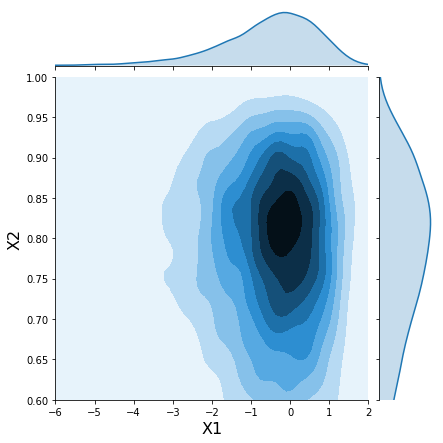

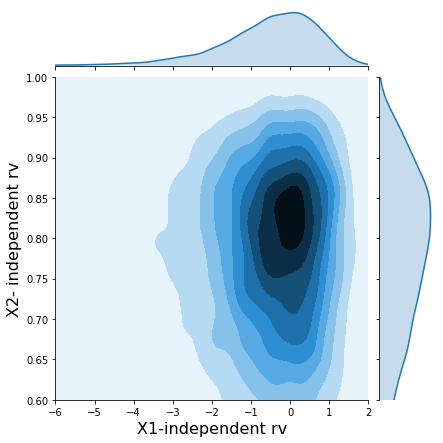

In [13]:
%matplotlib inline
import numpy as np
from scipy import stats
import scipy.linalg as la
import matplotlib.pyplot as plt
import seaborn as sns

# This program generates a Gaussian copula with a random correlation matrix to generate a N multivariate random variables
# each of whose marginals can be specified by any distribution. The output of this program would be a generation of samples 
# from the copula

# For a given R∈[−1,1]d×d, the Gaussian copula with parameter matrix R can be written as CGaussR(u)=ΦR(Φ−1(u1),…,Φ−1(ud)) 
#where Φ−1 is the inverse cumulative distribution function of a standard normal and ΦR is the joint cdf of a multivariate 
#normal distribution with mean vector zero and covariance matrix equal to the correlation matrix R.

#In the following code we went the opposite way to create samples from that distribution. The Gaussian copula as expressed 
# here takes uniform(0, 1) inputs, transforms them to be Gaussian, then applies the correlation and transforms them back to uniform.
# we use N =2 and plot the charts with the effects of using a copula vs using independent random variables. Modify code to 
# generate N>=2 as suited It will not happen by just changing value of N. you need to make sure that each column of the multivariate
# normal which is generated is assigned a marginal distribution of your choice.
##############################################################################################################################

np.random.seed(773) # remove this to create random samples in each run..this is to run a control experiment only

# INPUT- we need the number of variables with a given marginal distribution and correlation structure.
#**********************************************************************************************************************
N =100
high =200 # random number you can use anything you wish as the max random int to be generated
mean=np.zeros(N) # or you can provide mean = a N array with the expected values of the random variables.
v =np.ones(N) # or you can provide std =a N array with the std dev of of the random variables.( 1 is for std normal generation)
#***********************************************************************************************************************
eigsim = np.random.randint(high, size=(N,))
eigsim = N*eigsim/sum(eigsim)
x = stats.random_correlation.rvs((eigsim)) #random correlation generator
matmul= (np.dot(v[:,None],v[None,:]))
df_cov = np.multiply(matmul,x)
#print(df_cov)
mvnorm = stats.multivariate_normal(mean,df_cov )
# Generate random samples from multivariate normal with correlation randomly generated as shown by matrix 'x'


# In this part we are doing an example for a bivariate dstribution to show the impact of correlations First plt 
#shows the rv distributions with correlations The second simulates the bivariate rvs as independent rv samples.

x = mvnorm.rvs(10000)
print(len(x[2]))
x_unif = stats.norm.cdf(x) # Converting normal random variables into a uniform variable
gumbel = stats.gumbel_l()
beta = stats.beta(a=10,b=3)
h = sns.jointplot(gumbel.ppf(x_unif[:, 0]), beta.ppf(x_unif[:, 1]), kind='kde', xlim=(-6,2), ylim=(0.6,1.0),stat_func=None);
h.set_axis_labels('X1', 'X2', fontsize=16);
y = stats.multivariate_normal(np.zeros(N), np.eye(N)).rvs(10000) #generate samples from a standard normal variable
# with 0 mean 1 stddev and 0 correl
y_unif = stats.norm.cdf(y)
h = sns.jointplot(gumbel.ppf(y_unif[:, 0]), beta.ppf(y_unif[:, 1]), kind='kde', xlim=(-6, 2), ylim=(.6, 1.0),stat_func=None);
h.set_axis_labels('X1-independent rv', 'X2- independent rv',  fontsize=16);

In [ ]:
# This code fits a given data stream into a artilcuar continuous distribution as provided in the libray of scipy stats module
#The data stream is provided a singular array and this module checks the best fit based on SSE wrt all other distributions in 
# the database. One can add their own criteria- AIC, BIC etc to determine best fit as required.

import numpy as np
import warnings
from scipy import stats
dist_continu = [d for d in dir(stats.stats.distributions) if isinstance(getattr(stats.stats.distributions, d), stats.stats.distributions.rv_continuous)]
#dist_discrete = [d for d in dir(stats.stats.distributions) if isinstance(getattr(stats.stats.distributions, d), stats.stats.distributions.rv_discrete)]
#print('number of continuous distributions: %d' % len(dist_continu))
#print('number of discrete distributions:   %d' % len(dist_discrete))
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0
    dist_continu = [d for d in dir(stats.stats.distributions) if isinstance(getattr(stats.stats.distributions, d), stats.stats.distributions.rv_continuous)]
    dist_discrete = [d for d in dir(stats.stats.distributions) if isinstance(getattr(stats.stats.distributions, d), stats.stats.distributions.rv_discrete)]
    best_distribution = stats.uniform
    best_params = (0.0, 1.0)
    best_sse = np.inf
    i=0
    for distribution in dist_continu: 
         # Try to fit the distribution
        
        if (str(distribution)) == 'levy_stable':
            continue
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')
                a = distribution
                # fit dist to data
                params = eval("stats."+ str(distribution)).fit(data)
                
                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = eval("stats."+ str(distribution)).pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass
                
                # identify if this distribution is better
                if best_sse > sse:
                    best_distribution = eval("stats."+ str(distribution))
                    best_params = params
                    best_sse = sse
                print(distribution, sse)
        except Exception as e:
            print(e)
            pass
        i+=1
    return (best_distribution.name, best_params)
data = np.random.rand(1175)
x,y =(best_fit_distribution(data, bins=200, ax=None))
print(x,y[-2],y[-1])

In [3]:
# This piece of code reads a multi dimensional array from excel which has data of a multivariate distribution.
#The marginal distributions are assumed to have been already determined (using best fit or otherwise) and are provided 
#for the given data. This code then takes this data and creates a Gaussian copula and outputs the R∈[−1,1]d×d,which is needed 
# to further simuate samples using a copula. The samples generated can be used to test the goodness of fit for the multivariate
# data as required
import numpy as np
import math
import warnings
from scipy import stats
import pandas as pd
df = pd.read_excel('MultivariateData.xlsx', sheet_name='Sheet1') # enter the path or if it is in the same directory enter filename
data =df.as_matrix()
calc =np.zeros_like(data)
calc.reshape((len(data), len(df.columns)))
#print(data.shape)
#Assume the marginals are given or have been determined using best fit ( either the above code) or using a theoretical 
# basis that explains the natural process. We then assign each column to a marginal distribution below: We do an example 
#where we have 3 columns. One can expand this to as many columns by adding the data into Sheet1 of the excel file. You have
# to make sure you specify the marginals of every column you input below as shown.

dist ={}
dist[0] = stats.norm(20,10) # first column determined to be normally distributed with a mean of 20 and stdev 10
dist[1] = stats.expon(0,1/0.3) # second columns is specified as an exponential distributed rv with lambda = 0.3
dist[2] = stats.lognorm(0.5,0,math.exp(2)) # third is lognormally distributed with mean 2 and std dev 0.5


for i in range(len(df.columns)):
    for j in range(len(data)):
        calc[j][i] = 1-dist[i].sf(data[j][i]) # we have converted the marginals into a uniform RVs
correlS, pS =stats.spearmanr(calc) # correl is the correlations between the underlying cdf of the multivariate RVs which is the 
#R matrix for a Gaussian copula generator  is correlS
#***************************************************************************************************************************
# EXTRA STUFF TO CHECK which shows why doing a spearman is better than pearssons
#calculating the pearsons coefficient on the data 
correlationPdata = np.eye((len(df.columns)))
for i in range(len(df.columns)):
    for j in range(i+1):
        if(i==j):
            continue
        correlS2, pS2 = stats.pearsonr(data[:,i], data[:,j])
        correlationPdata[i][j]= correlS2
i_lower = np.tril_indices(len(df.columns), -1)
correlationPdata.T[i_lower] = correlationPdata[i_lower]
#print(calc)

#converting the uniform random variables frm the multivariate distributions to a standard normal random variable
normcalc= np.zeros_like(calc)
for i in range(len(df.columns)):
    for j in range(len(calc)):
        normcalc[j][i]= stats.norm.ppf(calc[j][i])
ct,ppp= stats.spearmanr(normcalc)
 # we see that the spearman coefficient is independent of the distributions as ct == correlS and only depends on rank

# calculating the pearsons coefficient on the cdf
correlationPcdf = np.eye((len(df.columns)))
for i in range(len(df.columns)):
    for j in range(i+1):
        if(i==j):
            continue
        correlS2, pS2 = stats.pearsonr(normcalc[:,i], normcalc[:,j])
        correlationPcdf[i][j]= correlS2
i_lower = np.tril_indices(len(df.columns), -1)
correlationPcdf.T[i_lower] = correlationPcdf[i_lower]
print(correlS,correlationPdata, correlationPcdf)

[[ 1.         -0.2688478   0.05168326]
 [-0.2688478   1.          0.04575628]
 [ 0.05168326  0.04575628  1.        ]] [[ 1.         -0.08145355  0.04891349]
 [-0.08145355  1.          0.05058345]
 [ 0.04891349  0.05058345  1.        ]] [[ 1.         -0.19200216  0.06992393]
 [-0.19200216  1.          0.01062693]
 [ 0.06992393  0.01062693  1.        ]]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':
